<a href="https://colab.research.google.com/github/M0hammad-Kashif/SketchToFace/blob/main/sketch_to_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Downloading

In [1]:
!echo '{"username":"mohammadkashif20","key":"029e913c85378ab69c8d83b71b3f3bcc"}' >> kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yewtsing/pretty-face

import zipfile
with zipfile.ZipFile("/content/pretty-face.zip","r") as zip_ref:
    zip_ref.extractall("Dataset")



!cp -R '/content/Dataset/face/face' ~+
!cp -R '/content/Dataset/layout/layout' ~+
!cp -R '/content/Dataset/sketch/sketch' ~+

!rm -rf '/content/Dataset'
!rm -rf '/content/sample_data'
!rm  '/content/pretty-face.zip'
!rm '/content/kaggle.json'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 1.17G/1.19G [00:10<00:00, 128MB/s]
100% 1.19G/1.19G [00:10<00:00, 118MB/s]


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.9 MB/s 
     |████████████████████████████████| 181 kB 63.9 MB/s 
     |████████████████████████████████| 157 kB 66.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 67.5 MB/s 
     |████████████████████████████████| 157 kB 69.5 MB/s 
     |████████████████████████████████| 157 kB 65.2 MB/s 
     |████████████████████████████████| 156 kB 59.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=52edb1c12d756e54f99d11e4e20ed839271d5513c03c267a45e4fa7de5874b5a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm
import wandb
import time
import gc

# Configurations

In [4]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LR = 1e-3
    BATCH_SIZE = 32
    IMG_CHANNEL = 3
    L1_LAMBDA = 100
    LAMBDA_GP = 10
    EPOCHS = 500
    IMG_SIZE = 256

# Dataloader and Transformations

In [5]:
face_path = '/content/face'
sketch_path = '/content/sketch'

face_file = os.listdir(face_path)
sketch_file = os.listdir(sketch_path)
print(len(face_file))
print(len(sketch_file))

3318
3318


(512, 512, 3)
(512, 512, 3)


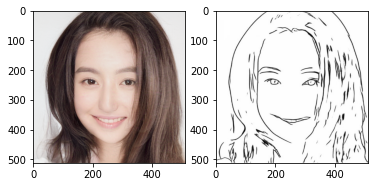

In [6]:
ix = randint(0,len(face_file))
file_name = face_file[ix]
face_img = Image.open(os.path.join(face_path, file_name))
face_img = np.array(face_img)
print(face_img.shape)
img_no = file_name.split('.')[0]
sketch_img = Image.open(os.path.join(sketch_path, img_no+'_edges.jpg'))
sketch_img = np.array(sketch_img)
print(sketch_img.shape)
plt.subplot(1,2,1)
plt.imshow(face_img)
plt.subplot(1,2,2)
plt.imshow(sketch_img)

In [7]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, dataloader
from torch.utils.data import DataLoader

In [8]:
IMAGE_SIZE = 256
IMG_CHANNELS = 3
BATCH_SIZE = 16

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms = A.Compose(
    [   
        A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
        A.Normalize(
         [0.5 for _ in range(CFG.IMG_CHANNEL)], [0.5 for _ in range(CFG.IMG_CHANNEL)]
        ),
        ToTensorV2(),
    ]
)

In [10]:
def img_arr(path, file):
  img = Image.open(os.path.join(path, file))
  img = np.array(img)

  return img

In [11]:
class CustomImageDataset(Dataset):
  def __init__(self, face_dir, sketch_dir, transform=None):
    self.face_dir = face_dir
    self.sketch_dir = sketch_dir
    self.face_files = os.listdir(self.face_dir)
    self.sketch_files = os.listdir(self.sketch_dir)
    self.transform = transform

  def __len__(self):
     return len(self.face_files)

  def __getitem__(self, idx):
    face_file = self.face_files[idx]
    face_img = img_arr(self.face_dir, face_file)
    img_no = face_file.split('.')[0]
    sketch_img = img_arr(self.sketch_dir, img_no+'_edges.jpg')

    if self.transform:
      face_img = self.transform(image=face_img)['image']
      sketch_img = self.transform(image=sketch_img)['image']

    return sketch_img, face_img  



In [12]:
dataset = CustomImageDataset(face_path, sketch_path,transforms)
dataloader = DataLoader(dataset, batch_size = CFG.BATCH_SIZE)

torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])


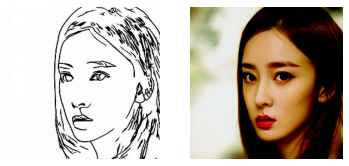

In [13]:
for idx , (sketch_img, face_img ) in enumerate(dataloader):
  print(sketch_img.shape)
  print(face_img.shape)
  plt.subplot(1,2,1)
  plt.imshow(sketch_img[4].permute(1,2,0))
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(face_img[4].permute(1,2,0))
  plt.axis("off")
  break

# Generator

In [14]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))



# Discriminator

In [15]:
import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


# Loss and Optimizers

In [16]:
disc = Discriminator(in_channels=CFG.IMG_CHANNEL).to(CFG.DEVICE).to(CFG.DEVICE)
gen = Generator(in_channels=CFG.IMG_CHANNEL, features=64).to(CFG.DEVICE).to(CFG.DEVICE)

opt_disc = optim.Adam(disc.parameters(), lr=CFG.LR, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=CFG.LR, betas=(0.5, 0.999))


BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

# Training part

In [23]:
def train_one_epoch(gen,disc,loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):

  pBar = tqdm(enumerate(loader),total=len(loader))

  for idx, (sketch, image) in pBar:

    sketch = sketch.to(CFG.DEVICE)
    image = image.to(CFG.DEVICE)  

    # training Discriminator
    with torch.cuda.amp.autocast():
      image_fake = gen(sketch)

      D_real = disc(sketch,image)
      D_real_loss = BCE(D_real,torch.ones_like(D_real))

      D_fake = disc(sketch , image_fake.detach())
      D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))

      D_loss = D_fake_loss + D_real_loss

    disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # Training Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(sketch,image_fake)
      G_fake_loss = BCE(D_fake,torch.ones_like(D_fake))
      L1 = L1_LOSS(image_fake,image)*CFG.L1_LAMBDA
      G_loss = G_fake_loss + L1

    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

    # if idx % 10 == 0:      
    #   pBar.set_postfix(
    #       D_real=torch.sigmoid(D_real).mean().item(),
    #       D_fake=torch.sigmoid(D_fake).mean().item(),
    #   )
    mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
    pBar.set_postfix(G_loss=f'{G_loss.item():0.4f}',
                       D_loss=f'{D_loss.item():0.4f}',
                      gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()









In [24]:
def train(CFG=CFG,loader=dataloader):

  wandb.init("Sketch2Face")
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  if torch.cuda.is_available():
    print("cuda: {}\n".format(torch.cuda.get_device_name()))

  start = time.time()

  for epoch in range(CFG.EPOCHS):

    print(f"Epoch {epoch + 1}")

    train_one_epoch(gen,disc,dataloader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler)
    print("-"*100)
    print("\n")






In [25]:
train()

cuda: Tesla P100-PCIE-16GB

Epoch 1


100%|██████████| 104/104 [02:28<00:00,  1.43s/it, D_loss=1.4423, G_loss=31.1596, gpu_mem=3.63 GB]


----------------------------------------------------------------------------------------------------


Epoch 2


100%|██████████| 104/104 [02:27<00:00,  1.41s/it, D_loss=1.3315, G_loss=27.1184, gpu_mem=3.63 GB]


----------------------------------------------------------------------------------------------------


Epoch 3


 91%|█████████▏| 95/104 [02:16<00:12,  1.44s/it, D_loss=1.3978, G_loss=23.6313, gpu_mem=4.24 GB]


KeyboardInterrupt: ignored